# QRt: QR Code Art Generator

This project is a part of the elective course on Generative Artificial Intelligence at Innopolis University.

It is a collaborative effort by our team members:

- Polina Zelenskaya, p.zelenskaya@innopolis.university
- Leila Khaertdinova, l.khaertdinova@innopolis.university
- Karina Denisova, k.denisova@innopolis.university
---
This notebook is a sandbox for testing hypotheses and proving concept of our ideas. The code provided below was designed to run in a cuda-compatable environment with at least 16GB of available memory on the Ubuntu system. For that reason, collab with the `T4 GPU` works perfectly.

## Required setups

In [1]:
!sudo apt-get install zbar-tools
!pip install -q git+https://github.com/huggingface/diffusers accelerate transformers==4.30.0 qrcode pyzbar
!pip install -q gradio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zbar-tools is already the newest version (0.23.92-4build2).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import qrcode
from PIL import Image
from pyzbar.pyzbar import decode
import torch
import transformers
from diffusers import UniPCMultistepScheduler
from diffusers import DPMSolverMultistepScheduler
from diffusers import ControlNetModel
from diffusers import StableDiffusionControlNetPipeline
import gradio

## Create a simple QR-code generator for a text/link

In [3]:
class BasicQR:
    """
    Main class to read/generate basic (target) QR-codes that are readable by any device
    """

    @staticmethod
    def generate(text: str, box_size: int = 10, border: int = 4) -> Image:
        """
        Generates valid qr-code for a given `text`
            > QR version is determined automatically
            > Error correction is at minimal (for smaller image sizes)
            > Black/white colors is used
        """

        # define generator
        qr = qrcode.QRCode(
            error_correction=qrcode.constants.ERROR_CORRECT_L,
            box_size=box_size,
            border=border
        )

        # add text and determine qr version
        qr.add_data(text)
        qr.make(fit=True)  # automatically determine qr version

        # generate and convert to PIL.Image
        return qr.make_image().convert('RGB')

    @staticmethod
    def read(img: Image) -> str or int:
        """
        Reads text data from given QR
            > Works on zbar-tools [please download them using apt-get]
            > If several qr-codes found, return only one (this functionallity is enough for this task)
            > Reader is robust enough so that even stable-diffusion generated once works nicely
            > If no valid QR-codes found, return -1
        """

        # decode image
        decoded = decode(img)

        # if nothing found, print warning and return `-1`
        if not decoded:
            print('Failed to find any QR')
            return -1
        else:
            print('The QR for:')
            return decoded[0].data.decode("utf-8")

## Define the models

We used Stable Diffusion model and Control Nets models using the following checkpoints:

1. control net brightness: `ioclab/control_v1p_sd15_brightness`
2. control net tile: `lllyasviel/control_v11f1e_sd15_tile`
3. stable diffusion: `SG161222/Realistic_Vision_V2.0`

In [4]:
class StableDiffusionWithControlNet:
    """
    Stable diffusion model with control net for QR-code generation
    """

    def __init__(
        self,
        device: str = 'cuda',
        brightness: str = "ioclab/control_v1p_sd15_brightness",
        title: str = "lllyasviel/control_v11f1e_sd15_tile",
        stable_diffusion_cp: str = "SG161222/Realistic_Vision_V2.0"
    ):

        # load controlnet models
        self.controlnet_brightness = ControlNetModel.from_pretrained(brightness)
        self.controlnet_tile = ControlNetModel.from_pretrained(title)

        # load stable diffusion
        self.stable_diffusion = StableDiffusionControlNetPipeline.from_pretrained(
            stable_diffusion_cp,
            controlnet=[self.controlnet_brightness, self.controlnet_tile]
            ).to(device)

        # define scheduler
        self.stable_diffusion.scheduler = DPMSolverMultistepScheduler.from_config(self.stable_diffusion.scheduler.config, use_karras_sigmas='true')

    def generate(
        self,
        prompt: str,
        qr_text: str,
        width: int = 768,
        height: str = 768,
        num_images_per_prompt: int = 1,
        num_inference_steps: int = 40
    ):
        """
        Generates QR-code based on prompt (given to stable diffusion) and qr_text (feeded to basic qr generator)
            > prompt - text that describes image style
            > qr_text - text that should be stored in qr
            > width - width of output image (better bigger for better performance)
            > height - height of output image (better bigger for better performance)
            > num_images_per_prompt - number of output images
            > num_inference_steps - number of inference steps (preferable 30, but 50+ provide better accuracy)
        """

        # define weights and guidance
        controlnets_weights = [0.35, 0.6]
        guidance_starts = [0, 0.3]
        guidance_stops = [1, 0.7]

        # generate target qr image
        qr_img = BasicQR.generate(qr_text)

        # generate images
        results = self.stable_diffusion(
            prompt,
            image=[qr_img, qr_img],
            num_inference_steps=num_inference_steps,
            width=width, height=height,
            num_images_per_prompt=num_images_per_prompt,
            control_guidance_start=guidance_starts,
            control_guidance_end=guidance_stops,
            controlnet_conditioning_scale=controlnets_weights
        )

        img = results.images[0]

        return img


model = StableDiffusionWithControlNet('cuda')

The config attributes {'dropout': 0.0, 'sample_size': 32} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.
safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


## Generate pleasing QR-code examples


  0%|          | 0/40 [00:00<?, ?it/s]

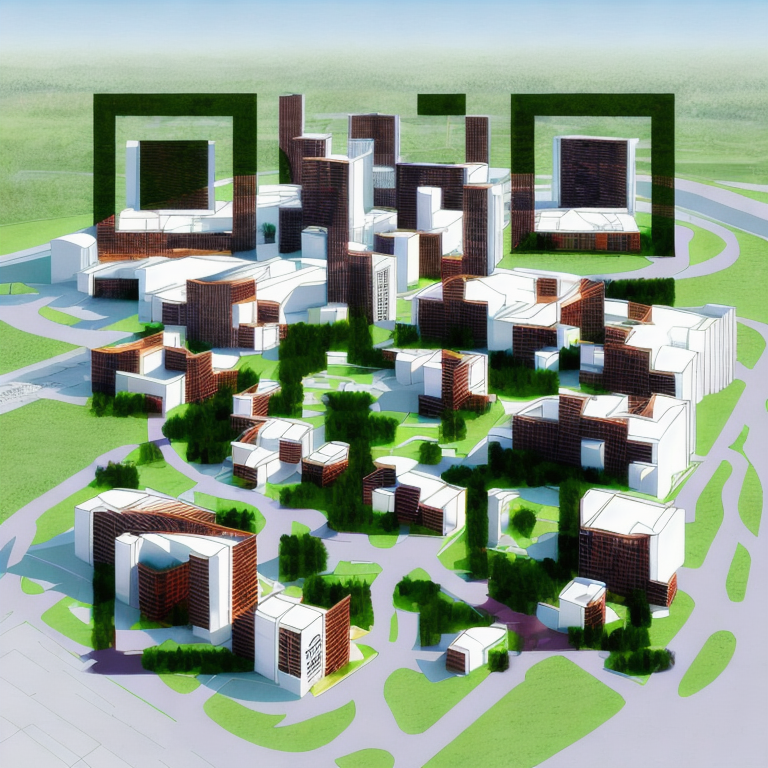

In [6]:
# another example usage: create a qr-code for innopolis university main site

generated_img = model.generate(prompt='innopolis university new campus design',
                               qr_text='https://innopolis.university')

generated_img


  0%|          | 0/40 [00:00<?, ?it/s]

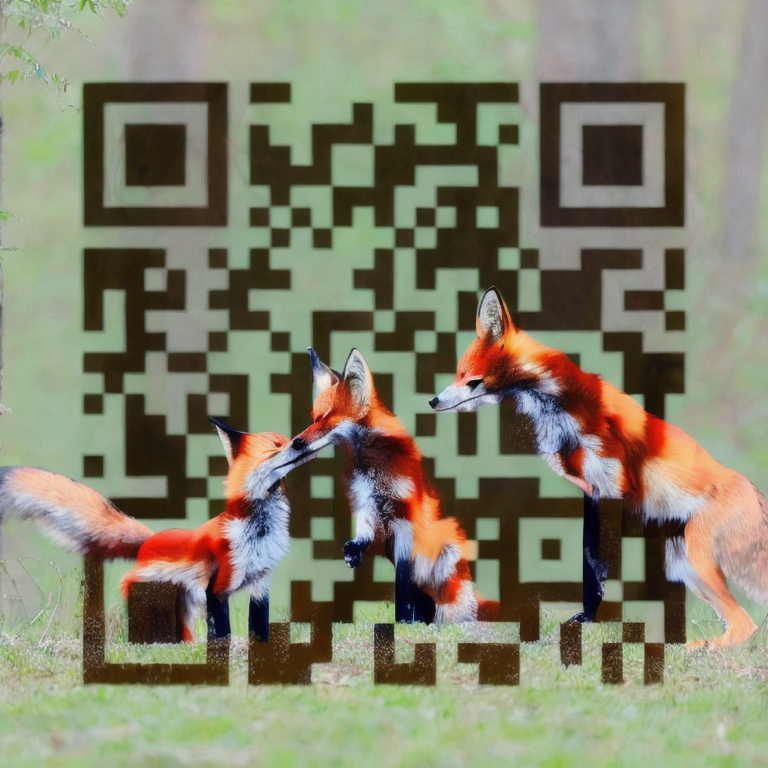

In [15]:
# example usage: create a qr-code for red fox documentary youtube video

generated_img_2 = model.generate(prompt='red foxes playing in the woods',
                               qr_text='https://www.youtube.com/watch?v=rBc6FExWvrw')

generated_img_2

## Downscale images so that it can be more easily scannable

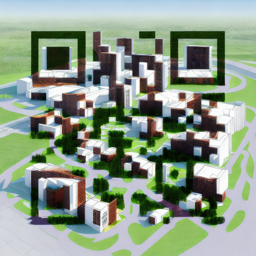

In [13]:
resized_generated_img = generated_img.resize((256,256))
resized_generated_img

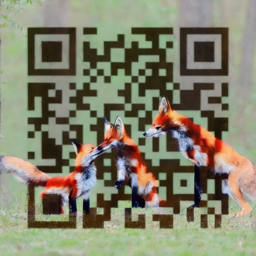

In [16]:
resized_generated_img_2 = generated_img_2.resize((256,256))
resized_generated_img_2

## Evaluate the results of QR-code AI generation

In [14]:
BasicQR.read(resized_generated_img)

The QR for:


'https://innopolis.university'

In [9]:
BasicQR.read(resized_generated_img_2)

The QR for:


'https://www.youtube.com/watch?v=rBc6FExWvrw'

As was obtained, both links read from a given QR-code are valid.

## Create a demo using Gradio visual interface

For this part, we decided to use gradio as simple and fast web interface.


In [17]:
demo = gradio.Interface(
    fn=model.generate,
    inputs=["text","text"],
    outputs="image",
    title="QR Code Generator",
    description="Enter the text for which you want to generate a QR code.",
    allow_flagging="never",

)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ace75fa47afada1f2a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
